```
This software is part of GPU Ocean. 

Copyright (C) 2018 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for all four numerical schemes, as reported under 
Section 4.8 Computational Efficiency in Test Cases for Rotational 
Shallow-Water Schemes by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Performance: Block Size Experiment

This notebook runs a few timesteps of each of the four numerical schemes on a range of different OpenCL block sizes.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time
import pyopencl
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "opencl_tuned_blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
#test_filename = "blocksize_benchmark_run_7.txt"
#test_filename = "blocksize_tuned_opencl_desktop_cdklm.txt"
print("Storing data in " + test_filename)

Storing data in blocksize_benchmark_run_0.txt


In [3]:
def runBenchmark(filename):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    sim = np.array(["CDKLM", "FBL", "CTCS"])
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))
    
    python_cmd = "python"
    if sys.version_info.major == 2:
        python_cmd = "python2"

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    
                    tic = time.time() 
                    
                    test_file.write("=========================================\n")
                    test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j]))
                    test_file.write("-----------------------------------------\n")
                    cmd = [ python_cmd, "run_benchmark.py", "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]), "--simulator", sim[k]]#, "--nx", "100", "--ny", "100", "--steps_per_download", "100"]
                    p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                    output = p.stdout.read()
                    test_file.write(str(output) + "\n")
                    test_file.write("=========================================\n")
                    test_file.write("\n")
                    
                    toc = time.time()
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 12 16 24 32]
Heights: [ 4  8 12 16 24 32]
CDKLM [04 x 04] completed in 62.74 s

CDKLM [04 x 08] completed in 41.14 s

CDKLM [04 x 12] completed in 36.41 s

CDKLM [04 x 16] completed in 30.97 s

CDKLM [04 x 24] completed in 29.76 s

CDKLM [04 x 32] completed in 28.97 s

CDKLM [08 x 04] completed in 36.94 s

CDKLM [08 x 08] completed in 25.84 s

CDKLM [08 x 12] completed in 23.41 s

CDKLM [08 x 16] completed in 22.67 s

CDKLM [08 x 24] completed in 22.65 s

CDKLM [08 x 32] completed in 23.75 s

CDKLM [12 x 04] completed in 29.43 s

CDKLM [12 x 08] completed in 23.65 s

CDKLM [12 x 12] completed in 21.96 s

CDKLM [12 x 16] completed in 21.91 s

CDKLM [12 x 24] completed in 22.45 s

CDKLM [12 x 32] completed in 22.70 s

CDKLM [16 x 04] completed in 25.04 s

CDKLM [16 x 08] completed in 21.44 s

CDKLM [16 x 12] completed in 20.79 s

CDKLM [16 x 16] completed in 22.16 s

CDKLM [16 x 24] completed in 21.90 s

CDKLM [16 x 32] completed in 24.04 s

CDK

In [4]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['CDKLM' '04' '04' '140.57078209']
 ['CDKLM' '04' '08' '219.25953471']
 ['CDKLM' '04' '12' '250.11257640']
 ['CDKLM' '04' '16' '298.28585947']
 ['CDKLM' '04' '24' '311.45160574']
 ['CDKLM' '04' '32' '321.60254882']
 ['CDKLM' '08' '04' '246.14297594']
 ['CDKLM' '08' '08' '365.30192604']
 ['CDKLM' '08' '12' '407.41000477']
 ['CDKLM' '08' '16' '423.72357860']
 ['CDKLM' '08' '24' '425.18529260']
 ['CDKLM' '08' '32' '401.06846145']
 ['CDKLM' '12' '04' '315.58150038']
 ['CDKLM' '12' '08' '402.79900319']
 ['CDKLM' '12' '12' '437.64794393']
 ['CDKLM' '12' '16' '439.52094583']
 ['CDKLM' '12' '24' '427.03090242']
 ['CDKLM' '12' '32' '422.17258158']
 ['CDKLM' '16' '04' '379.22774498']
 ['CDKLM' '16' '08' '450.61189011']
 ['CDKLM' '16' '12' '467.36653510']
 ['CDKLM' '16' '16' '433.89627469']
 ['CDKLM' '16' '24' '442.03865924']
 ['CDKLM' '16' '32' '395.24124962']
 ['CDKLM' '24' '04' '390.91683159']
 ['CDKLM' '24' '08' '460.87631368']
 ['CDKLM' '24' '12' '445.05427209']
 ['CDKLM' '24' '16' '449.226

['04' '08' '12' '16' '24' '32']
CDKLM
         04       08       12       16       24       32
04  140.571   219.26  250.113  298.286  311.452  321.603
08  246.143  365.302   407.41  423.724  425.185  401.068
12  315.582  402.799  437.648  439.521  427.031  422.173
16  379.228  450.612  467.367  433.896  442.039  395.241
24  390.917  460.876  445.054  449.226  415.186   299.42
32  478.185  510.576  526.366  474.359  343.747  404.187
Maximum=526.37
Minimum=140.57
Mean=389.48


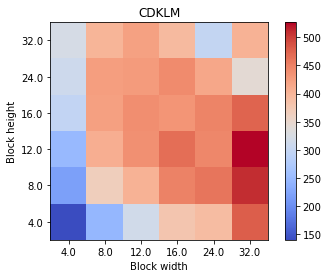

In [5]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.float32)
    y = df.columns.values.astype(np.float32)
    z = np.transpose(df.values.astype(np.float32))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.coolwarm, interpolation="None")
    plt.colorbar(img)
    plt.xticks( range(len(x)), x )
    ax.set_xlabel('Block width')
    plt.yticks( range(len(y)), y )
    ax.set_ylabel('Block height')
    plt.title(simulator)
    plt.savefig(test_filename.replace('.txt', '.png'))
    